In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('Sales Forecasting data.csv', parse_dates=[0])
dataSize = len(df)
df.head()

,Date,Sales_Qty,Sales_Value
0,2020-12-02,-75.00000,-7260.280000
1,2020-12-03,475.00000,44989.300000
2,2020-12-04,84.00000,8407.150000
3,2020-12-05,200.00000,19769.990000
4,2020-12-06,232.26985,22706.384254


In [5]:
dataMat = df['Sales_Value'].values.reshape(dataSize,1)
dataMat.shape

(939, 1)

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaledDataMat = scaler.fit_transform(dataMat)

In [7]:
train_split = 0.7

train_size = int(train_split * dataSize)

trainData = scaledDataMat[:train_size]
valData = scaledDataMat[train_size:]

print('Train data size: ', trainData.shape)
print('Val data size: ', valData.shape)

Train data size:  (657, 1)
Val data size:  (282, 1)


In [8]:
def createDataset(dataset, time_step=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step)])
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

In [9]:
n_past = 4

X_train,y_train = createDataset(trainData, time_step=n_past)
X_val,y_val = createDataset(valData, time_step=n_past)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(653, 4, 1) (653, 1)
(278, 4, 1) (278, 1)


In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(n_past,1)))
model.add(LSTM(64, return_sequences=False, input_shape=(n_past,1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=1,verbose=1, callbacks=[callback])

Epoch 1/50
653/653 [==============================] - 5s 4ms/step - loss: 0.0097 - val_loss: 0.0054
Epoch 2/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 3/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 4/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 5/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 6/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 7/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 8/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 9/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 10/50
653/653 [==============================] - 2s 3ms/step - loss: 0.0052 - val_loss: 0.0051

In [11]:
y_train_hat = scaler.inverse_transform(model.predict(X_train))

y_val_hat = scaler.inverse_transform(model.predict(X_val))

9/9 [==============================] - 0s 864us/step


In [12]:
train_shift = n_past

test_shift = train_shift + len(y_train_hat) + n_past

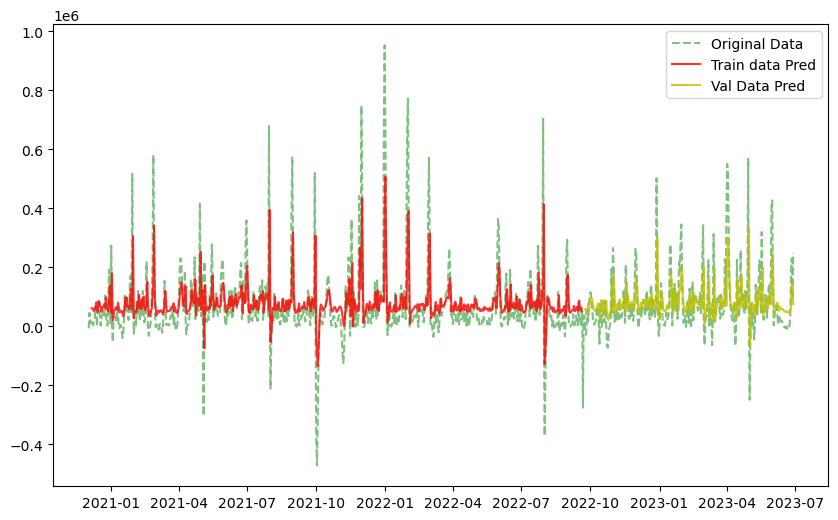

In [13]:
plt.figure(figsize = (10,6))

plt.plot(df['Date'], df['Sales_Value'], color='g', label="Original Data", alpha = 0.5, ls = '--')
plt.plot(df['Date'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train data Pred", alpha = 0.8)
plt.plot(df['Date'][test_shift:], y_val_hat, color='y', label="Val Data Pred", alpha = 0.8)
plt.legend()

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
np.sqrt(mean_squared_error(y_val_hat, y_val))

93481.33878956646